In [1]:
import einsum_benchmark
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

In [2]:
def get_tensor_info(instance):
    biggest_dim = 0
    biggest_number_of_dims = 0
    for tensor in instance.tensors:
        for dim in tensor.shape:
            if dim > biggest_dim:
                biggest_dim = dim
            if len(tensor.shape) > biggest_number_of_dims:
                biggest_number_of_dims = len(tensor.shape)
    return len(instance.tensors), biggest_dim, biggest_number_of_dims
        
def get_benchmarks(threshold: int = None):
    benchmark_data = {}
    idx = 0
    for instance in einsum_benchmark.instances:
        if threshold and len(instance.tensors) > threshold:
            continue
        benchmark_data[instance.name] = [idx, get_tensor_info(instance)]
        idx+=1
    return benchmark_data

In [3]:
#benchmark_data = get_benchmarks()
benchmark_data = get_benchmarks(1000)

Text(0.5, 1.0, 'Biggest tensor rank')

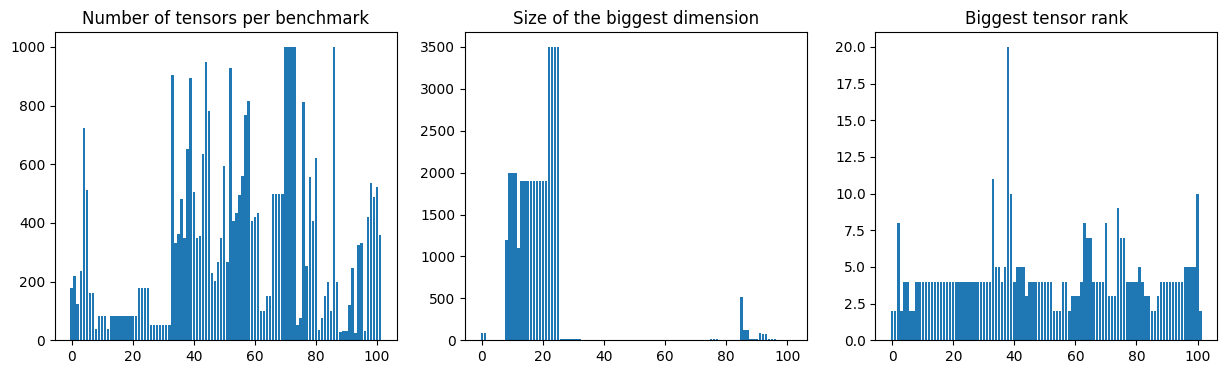

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].bar([i[0] for i in benchmark_data.values()], [i[1][0] for i in benchmark_data.values()])
axs[0].set_title("Number of tensors per benchmark")
axs[1].bar([i[0] for i in benchmark_data.values()], [i[1][1] for i in benchmark_data.values()])
axs[1].set_title("Size of the biggest dimension")
axs[2].bar([i[0] for i in benchmark_data.values()], [i[1][2] for i in benchmark_data.values()])
axs[2].set_title("Biggest tensor rank")

In [5]:
#position, number of tensors, size of the biggest dimension, max number of dims
print(len(benchmark_data))

102


In [6]:
# --- Load and preprocess ---
df = pd.read_csv("einsum-data/13_90_5_complete.txt")
df.columns = df.columns.str.strip()
df = df.loc[df["file_name"] != "mc_2021_027.txt"]
df["benchmark_id"] = df["file_name"].factorize()[0] + 1

# Method labeling
def method_label(row):
    if row["format"] == "dense":
        return "Dense"
    elif row["format"] == "sparse" and row["propagate"] == 0:
        return "Sparse (prop=false)"
    elif row["format"] == "sparse" and row["propagate"] == 1:
        return "Sparse (prop=true)"
    else:
        return "Other"

df["method"] = df.apply(method_label, axis=1)
df = df.sort_values(by=['benchmark_id', 'format'])

# --- Normalization per benchmark ---
def normalize_metric(metric):
    dense_values = df.loc[df["method"] == "Dense", ["benchmark_id", metric]]
    dense_values = dense_values.rename(columns={metric: f"{metric}_dense"})

    merged = df.merge(dense_values, on="benchmark_id", how="left")
    merged[f"{metric}_norm"] = merged[metric] / merged[f"{metric}_dense"]
    return merged

df = normalize_metric("runtime")
df = normalize_metric("overall_memory")
df = normalize_metric("tensors-size")

# --- Filter out Dense bars ---
df_sparse = df[df["method"] != "Dense"]

# --- 1. Runtime comparison (normalized) ---
fig_runtime = px.bar(
    df_sparse,
    x="benchmark_id",
    y="runtime_norm",
    color="method",
    barmode="group",
    labels={"benchmark_id": "Benchmark ID", "runtime_norm": "Runtime (normalized to Dense)"},
    title="Normalized Runtime Comparison",
    color_discrete_sequence=px.colors.qualitative.Safe,
)
fig_runtime.update_layout(legend=dict(orientation="h", yanchor="top", y=-0.3,
                                      xanchor="center", x=0.5), plot_bgcolor='white', legend_title=None)
fig_runtime.show()

# --- 2. Memory comparison (normalized) ---
fig_memory = px.bar(
    df_sparse,
    x="benchmark_id",
    y="overall_memory_norm",
    color="method",
    barmode="group",
    labels={"benchmark_id": "Benchmark ID", "overall_memory_norm": "Memory (normalized to Dense)"},
    title="Normalized Overall Memory Comparison",
    color_discrete_sequence=px.colors.qualitative.Safe,
)
fig_memory.update_layout(legend=dict(orientation="h", yanchor="top", y=-0.3,
                                      xanchor="center", x=0.5), plot_bgcolor='white', legend_title=None)
fig_memory.show()

# --- 3. Tensor size comparison (normalized) ---
fig_tensors = px.bar(
    df_sparse,
    x="benchmark_id",
    y="tensors-size_norm",
    color="method",
    barmode="group",
    labels={"benchmark_id": "Benchmark ID", "tensors-size_norm": "Tensor Size (normalized to Dense)"},
    title="Normalized Tensor Size Comparison",
    color_discrete_sequence=px.colors.qualitative.Safe,
)
fig_tensors.update_layout(legend=dict(orientation="h", yanchor="top", y=-0.3,
                                      xanchor="center", x=0.5), plot_bgcolor='white', legend_title=None)
fig_tensors.show()

In [7]:
df_sparse = df[df["method"] == "Sparse (prop=true)"]

df_melt = df_sparse.melt(
    id_vars=["file_name", "method", "benchmark_id"],
    value_vars=["analysis", "compilation_time", "runtime"],
    var_name="metric",
    value_name="value"
)

df_melt["metric"] = df_melt["metric"]

fig = px.bar(
    df_melt,
    x="benchmark_id",
    y="value",
    color="metric",
    barmode="group",
    log_y=True,
    labels={"value": "Time (s)", "benchmark_id": "Benchmark ID", "runtime": "Runtime"},
    #title="Analysis Time vs Compilation Time vs Runtime - sparse+prop=true (Log Scale)",
    color_discrete_sequence=px.colors.qualitative.Safe,
)
fig.update_layout(
    legend=dict(orientation="h", yanchor="top", xanchor="center", x=0.5),
    plot_bgcolor="white", legend_title=None

)
fig.write_image("my_plot.svg")
fig.show()


In [8]:
def read_csv(file_name):
    df = pd.read_csv(file_name)
    df = df.loc[df["file_name"] != "mc_2021_027.txt"]
    df.columns = df.columns.str.strip()
    df["benchmark_id"] = df["file_name"].factorize()[0] + 1
    df["method"] = df.apply(method_label, axis=1)
    df = df.sort_values(by=['benchmark_id', 'format'])
    return df

def filter_sparse(df):
    return df.loc[df['method'] == 'Sparse (prop=true)']

def filter_dense(df):
    #return df.loc[(df['method'] == 'Sparse (prop=false)') & (df['sparsity'] == 0.9)]
    return df.loc[df['method'] == 'Dense']

def get_avg(df):
    avg_cols = ["load_time", "compilation_time", "runtime", "overall_memory", "tensors-size"]

    df_avg = (
        df.groupby("file_name", as_index=False)
          .agg({
              "format": "first",
              "sparsity": "mean",
              "propagate": "first",
              "ratio_before": "mean",
              "ratio_after": "mean",
              "analysis": "mean",
              "load_time": "mean",
              "compilation_time": "mean",
              "runtime": "mean",
              "overall_memory": "mean",
              "tensors-size": "mean",
              "benchmark_id": "first",
              "method": "first"
          })
    )
    df_avg = df_avg.sort_values(by=['benchmark_id', 'format'])
    return df_avg

df_90 = read_csv("einsum-data/13_90_5_complete.txt")
df_70 = read_csv("einsum-data/13_70_5_complete.txt")
df_50 = read_csv("einsum-data/13_50_5_complete.txt")
df_30 = read_csv("einsum-data/13_30_5_complete.txt")

full_df = pd.concat([df_90, df_70, df_50, df_30])

full_sparse_df =  filter_sparse(full_df)
full_dense_df =  get_avg(filter_dense(full_df))

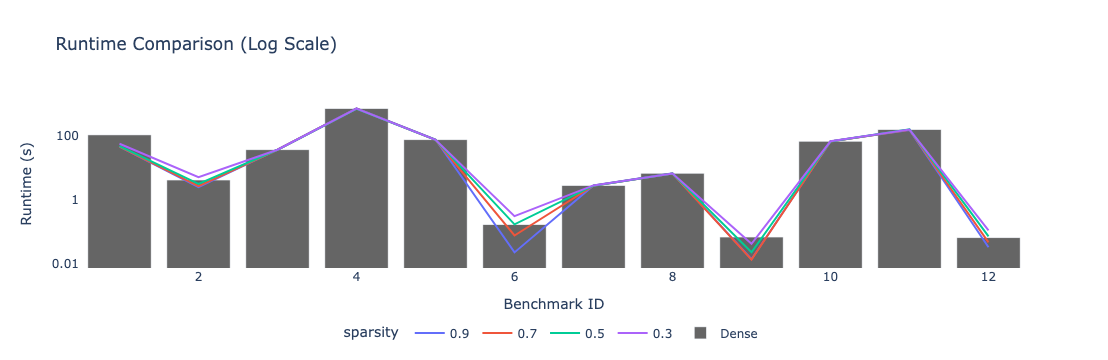

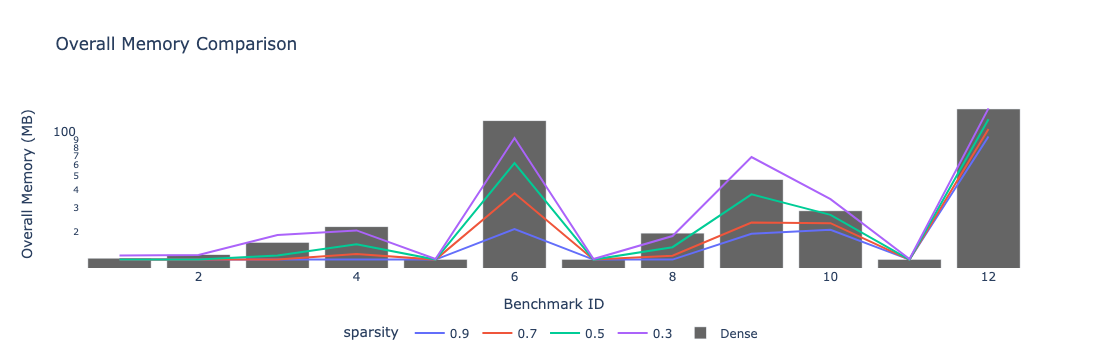

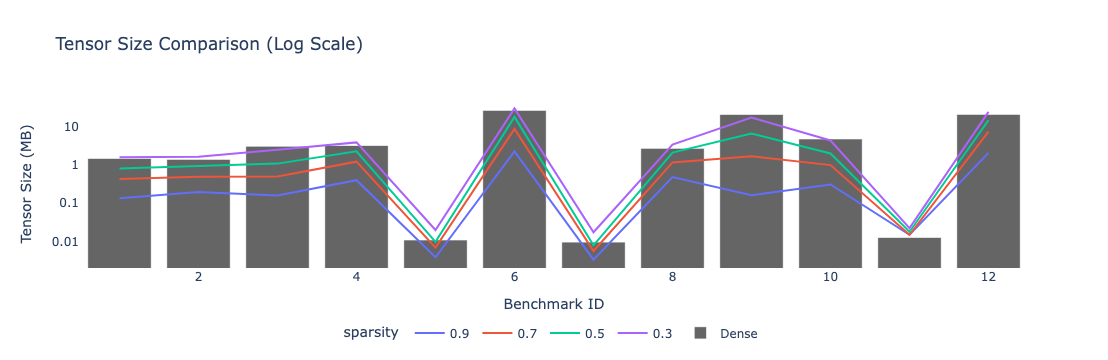

In [9]:
fig_runtime = px.line(
    full_sparse_df,
    x="benchmark_id",
    y="runtime",
    color="sparsity",
    labels={"benchmark_id": "Benchmark ID", "runtime": "Runtime (s)"},
    title="Runtime Comparison (Log Scale)", log_y=True,
)

fig_runtime.add_trace(
    go.Bar(
        x=full_dense_df["benchmark_id"],
        y=full_dense_df["runtime"],
        name="Dense",
        marker_color="black",
        opacity=0.6,
    )
)
fig_runtime.update_layout(legend=dict(orientation="h", yanchor="top", y=-0.3, xanchor="center", x=0.5), plot_bgcolor='white')
fig_runtime.show()

fig_memory = px.line(
    full_sparse_df,
    x="benchmark_id",
    y="overall_memory",
    color="sparsity",
    labels={"benchmark_id": "Benchmark ID", "overall_memory": "Overall Memory (MB)"},
    title="Overall Memory Comparison",log_y=True,
)
fig_memory.add_trace(
    go.Bar(
        x=full_dense_df["benchmark_id"],
        y=full_dense_df["overall_memory"],
        name="Dense",
        marker_color="black",
        opacity=0.6,
    )
)
fig_memory.update_layout(legend=dict(orientation="h", yanchor="top", y=-0.3, xanchor="center", x=0.5), plot_bgcolor='white')
fig_memory.show()

fig_tensors = px.line(
    full_sparse_df,
    x="benchmark_id",
    y="tensors-size",
    color="sparsity",
    labels={"benchmark_id": "Benchmark ID", "tensors-size": "Tensor Size (MB)"},
    title="Tensor Size Comparison (Log Scale)", log_y=True,
)
fig_tensors.add_trace(
    go.Bar(
        x=full_dense_df["benchmark_id"],
        y=full_dense_df["tensors-size"],
        name="Dense",
        marker_color="black",
        opacity=0.6,
    )
)
fig_tensors.update_layout(legend=dict(orientation="h", yanchor="top", y=-0.3, xanchor="center", x=0.5), plot_bgcolor='white')
fig_tensors.show()
fig_tensors.write_image("my_plot.svg")

In [10]:
priority = [
    "str_nw_ftps_open_30.txt",
    "str_nw_ftps_open_28.txt",
    "gm_queen5_5_3.wcsp.txt",
]